In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys

import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)

## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [ ]:
#radvass speech and song
import time
import os
import librosa
from librosa import display
import matplotlib.pyplot as plt

count=0
path1 = '/content/drive/My Drive/data_set/RAVDESS_speech'
path2 = '/content/drive/My Drive/data_set/RAVDESS_song'

lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path2):
  #print(dirs)
  #print(subdir)
  #print(files)
  for file in files:
      try:
        count +=1
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        #mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        emo = int(file[7:8]) - 1 
        arr = X, emo
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

for subdir, dirs, files in os.walk(path1):
  #print(dirs)
  #print(subdir)
 # print(files)
  for file in files:
      try:
        emo = int(file[7:8]) - 1 
        if(emo==6 or emo==7):
          continue
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        #mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        count +=1
        arr = X, emo
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 540.6192402839661 seconds ---


In [ ]:
from numpy.core.fromnumeric import size
size(lst)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



4136

In [ ]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
audio_file, emotion = zip(*lst)

In [ ]:
audio_file=np.asarray(audio_file)
emotion=np.asarray(emotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
emotion.shape,audio_file.shape

((2068,), (2068,))

In [ ]:
from sklearn.model_selection import train_test_split

signal_train, signal_test, emo_train, emo_test = train_test_split(audio_file,emotion, test_size=0.20, random_state=42)

In [ ]:
signal_valid, signal_test, emo_valid, emo_test = train_test_split(signal_test,emo_test, test_size=0.5,train_size=0.5, random_state=42)

In [ ]:
signal_train.shape,signal_valid.shape,signal_test.shape

((1654,), (207,), (207,))

In [ ]:
x_valid=[]
x_test=[]
for i in range(signal_valid.size):
  x_valid.append(np.mean(librosa.feature.mfcc(y=signal_valid[i], sr=sample_rate, n_mfcc=40).T,axis=0))
  #x_valid.append(np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(signal_valid[i])), sr=sample_rate ,n_chroma=12).T,axis=0))

for i in range(signal_test.size):
  x_test.append(np.mean(librosa.feature.mfcc(y=signal_test[i], sr=sample_rate, n_mfcc=40).T,axis=0))
  #x_test.append(np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(signal_test[i])), sr=sample_rate,n_chroma=12).T,axis=0))

In [ ]:
x_valid=np.asarray(x_valid)
x_test=np.asarray(x_test)

In [ ]:
x_valid.shape,x_test.shape

((207, 40), (207, 40))

In [ ]:
train_lst=[]
for i in range(signal_train.size):
  emo=emo_train[i]
  x=signal_train[i]
  arr=x,emo
  train_lst.append(arr)
  x=librosa.effects.time_stretch(signal_train[i],0.5)
  arr=x,emo
  train_lst.append(arr)
  x=librosa.effects.time_stretch(signal_train[i],1.5)
  arr=x,emo
  train_lst.append(arr)
  x=librosa.effects.pitch_shift(signal_train[i],sample_rate,2)
  arr=x,emo
  train_lst.append(arr)

In [ ]:
signal, y_train = zip(*train_lst)

In [ ]:
signal=np.asarray(signal)
y_train=np.asarray(y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [ ]:
x_train=[]
for i in range(signal.size):
  x_train.append(np.mean(librosa.feature.mfcc(y=signal[i], sr=sample_rate, n_mfcc=40).T,axis=0))
  #x_train.append(np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(signal_valid[i])), sr=sample_rate , n_chroma=12 ).T,axis=0))

In [ ]:
x_train=np.asarray(x_train)

In [ ]:
x_train.shape

(6616, 40)

In [ ]:
y_train.shape

(6616,)

In [ ]:
# soruce:(https://keras.io/examples/nlp/text_classification_with_transformer/)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [ ]:
'''embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer'''
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv1D(64, 5,padding='same', #classifier.add(Convolution2D(64, (3, 3), padding = 'same', input_shape = (128, 128, 3), activation = 'relu'))
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(TransformerBlock(256, 2, 256))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07, decay=0.0)
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
#adding new layer
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


model = Sequential()

model.add(Conv1D(64, 5,padding='same', #classifier.add(Convolution2D(64, (3, 3), padding = 'same', input_shape = (128, 128, 3), activation = 'relu'))
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07, decay=0.0)
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
#changing dropout
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


model = Sequential()

model.add(Conv1D(64, 5,padding='same', #classifier.add(Convolution2D(64, (3, 3), padding = 'same', input_shape = (128, 128, 3), activation = 'relu'))
                 input_shape=(40,1)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('sigmoid'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07, decay=0.0)
#opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 40, 64)            384       
                                                                 
 activation_3 (Activation)   (None, 40, 64)            0         
                                                                 
 dropout_5 (Dropout)         (None, 40, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 128)           41088     
                                                                 
 activation_4 (Activation)   (None, 10, 128)           0         
                                                      

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_train, y_train, batch_size=16, epochs=500, validation_data=(x_valid, emo_valid))
#cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,validation_split=0.1)

Epoch 1/500
414/414 [==============================] - 16s 32ms/step - loss: 1.8232 - accuracy: 0.2355 - val_loss: 1.5687 - val_accuracy: 0.3140
Epoch 2/500
414/414 [==============================] - 14s 34ms/step - loss: 1.6449 - accuracy: 0.2959 - val_loss: 1.5811 - val_accuracy: 0.3237
Epoch 3/500
414/414 [==============================] - 13s 31ms/step - loss: 1.5467 - accuracy: 0.3430 - val_loss: 1.3366 - val_accuracy: 0.4686
Epoch 4/500
414/414 [==============================] - 13s 31ms/step - loss: 1.4680 - accuracy: 0.3974 - val_loss: 1.7033 - val_accuracy: 0.3188
Epoch 5/500
414/414 [==============================] - 13s 31ms/step - loss: 1.3874 - accuracy: 0.4262 - val_loss: 1.9445 - val_accuracy: 0.2995
Epoch 6/500
414/414 [==============================] - 13s 31ms/step - loss: 1.3282 - accuracy: 0.4500 - val_loss: 1.6325 - val_accuracy: 0.3913
Epoch 7/500
414/414 [==============================] - 13s 31ms/step - loss: 1.2574 - accuracy: 0.4912 - val_loss: 1.4854 - val_ac

In [ ]:
ava_acc=np.mean(cnnhistory.history['accuracy']) # numpy assumed imported as np
print(ava_acc)

0.9729195060048784


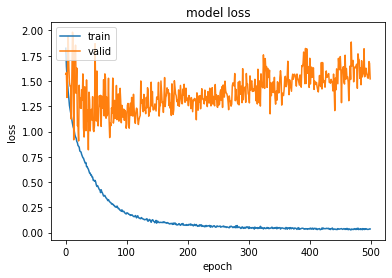

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

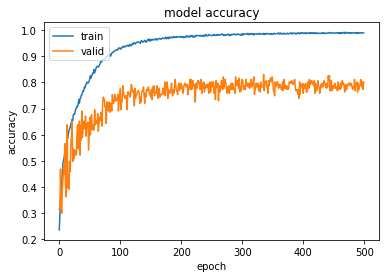

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
#predictions = model.predict_classes(x_testcnn)
predictions = model.predict(x_test)

In [ ]:
predictions

array([[4.6198365e-10, 1.8152556e-09, 4.0100247e-07, 7.1351214e-09,
        1.7429281e-07, 9.9999940e-01],
       [1.1850429e-11, 1.0000000e+00, 1.2590620e-09, 1.7435681e-10,
        3.5941105e-12, 1.0201466e-09],
       [1.0650972e-09, 1.2112294e-07, 9.9999845e-01, 1.3081614e-06,
        4.0219281e-09, 1.4907130e-07],
       ...,
       [2.4001625e-09, 5.5616333e-08, 2.6401045e-08, 9.5569618e-08,
        9.9999738e-01, 2.3851198e-06],
       [3.9959229e-03, 4.6212052e-05, 5.4937057e-02, 4.1085473e-01,
        1.5157159e-08, 5.3016603e-01],
       [9.5255939e-07, 1.8694940e-06, 4.3608645e-07, 2.5223384e-08,
        9.9999666e-01, 5.9508682e-08]], dtype=float32)

In [ ]:
emo_test

array([5, 1, 2, 5, 3, 4, 2, 0, 3, 1, 3, 2, 1, 4, 3, 0, 5, 0, 2, 5, 0, 0,
       1, 3, 2, 3, 2, 5, 4, 2, 2, 3, 1, 2, 5, 5, 3, 5, 3, 3, 4, 1, 3, 2,
       3, 1, 5, 3, 1, 2, 4, 4, 5, 5, 5, 1, 2, 3, 2, 5, 0, 2, 4, 2, 5, 4,
       3, 0, 1, 2, 5, 2, 1, 2, 4, 5, 4, 1, 5, 5, 3, 1, 5, 3, 2, 4, 2, 5,
       0, 5, 0, 5, 4, 0, 2, 4, 0, 2, 2, 0, 2, 3, 5, 3, 5, 5, 3, 1, 2, 2,
       2, 1, 3, 2, 1, 3, 4, 4, 1, 1, 2, 4, 4, 1, 4, 2, 0, 4, 5, 5, 3, 1,
       2, 1, 5, 5, 1, 2, 3, 3, 0, 3, 3, 0, 1, 0, 1, 2, 1, 5, 1, 2, 2, 0,
       1, 1, 1, 1, 1, 4, 0, 1, 5, 1, 4, 5, 5, 4, 1, 0, 3, 5, 2, 3, 0, 4,
       1, 3, 1, 0, 5, 5, 3, 5, 4, 5, 4, 0, 4, 1, 2, 1, 5, 0, 4, 3, 2, 1,
       0, 3, 5, 0, 4, 5, 4, 5, 4])

In [ ]:
new_Ytest = emo_test.astype(int)

In [ ]:
new_Ytest

array([5, 1, 2, 5, 3, 4, 2, 0, 3, 1, 3, 2, 1, 4, 3, 0, 5, 0, 2, 5, 0, 0,
       1, 3, 2, 3, 2, 5, 4, 2, 2, 3, 1, 2, 5, 5, 3, 5, 3, 3, 4, 1, 3, 2,
       3, 1, 5, 3, 1, 2, 4, 4, 5, 5, 5, 1, 2, 3, 2, 5, 0, 2, 4, 2, 5, 4,
       3, 0, 1, 2, 5, 2, 1, 2, 4, 5, 4, 1, 5, 5, 3, 1, 5, 3, 2, 4, 2, 5,
       0, 5, 0, 5, 4, 0, 2, 4, 0, 2, 2, 0, 2, 3, 5, 3, 5, 5, 3, 1, 2, 2,
       2, 1, 3, 2, 1, 3, 4, 4, 1, 1, 2, 4, 4, 1, 4, 2, 0, 4, 5, 5, 3, 1,
       2, 1, 5, 5, 1, 2, 3, 3, 0, 3, 3, 0, 1, 0, 1, 2, 1, 5, 1, 2, 2, 0,
       1, 1, 1, 1, 1, 4, 0, 1, 5, 1, 4, 5, 5, 4, 1, 0, 3, 5, 2, 3, 0, 4,
       1, 3, 1, 0, 5, 5, 3, 5, 4, 5, 4, 0, 4, 1, 2, 1, 5, 0, 4, 3, 2, 1,
       0, 3, 5, 0, 4, 5, 4, 5, 4])

In [ ]:
preds1=predictions.argmax(axis=1)

In [ ]:
preds1

array([5, 1, 2, 5, 3, 4, 2, 0, 3, 0, 3, 2, 1, 4, 3, 0, 5, 3, 2, 5, 5, 1,
       1, 3, 2, 3, 2, 5, 2, 5, 2, 3, 1, 2, 5, 5, 1, 5, 3, 2, 5, 1, 3, 5,
       3, 1, 5, 3, 1, 4, 4, 4, 5, 2, 3, 1, 2, 3, 2, 5, 0, 2, 4, 2, 5, 4,
       3, 4, 1, 2, 5, 2, 1, 2, 5, 2, 4, 1, 5, 2, 3, 1, 5, 3, 2, 4, 2, 5,
       1, 5, 0, 5, 4, 1, 0, 4, 3, 5, 2, 0, 2, 2, 0, 3, 5, 5, 3, 1, 2, 2,
       2, 1, 3, 2, 1, 4, 4, 4, 1, 1, 2, 4, 4, 1, 4, 2, 0, 4, 5, 5, 3, 1,
       2, 1, 5, 5, 1, 4, 3, 3, 0, 3, 5, 0, 5, 0, 1, 2, 3, 5, 1, 2, 5, 1,
       1, 1, 2, 1, 1, 4, 0, 1, 5, 1, 4, 5, 5, 4, 1, 0, 2, 5, 2, 3, 1, 4,
       1, 3, 1, 0, 5, 5, 3, 5, 4, 5, 3, 0, 0, 1, 2, 1, 2, 0, 4, 3, 2, 1,
       1, 3, 5, 0, 4, 5, 4, 5, 4])

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(new_Ytest, abc) 
c

array([[15,  6,  0,  2,  1,  1],
       [ 1, 35,  1,  1,  0,  1],
       [ 1,  0, 31,  0,  2,  4],
       [ 0,  1,  3, 27,  1,  1],
       [ 1,  0,  1,  1, 25,  2],
       [ 1,  0,  4,  1,  0, 36]])

In [ ]:
emo_test

array([5, 1, 2, 5, 3, 4, 2, 0, 3, 1, 3, 2, 1, 4, 3, 0, 5, 0, 2, 5, 0, 0,
       1, 3, 2, 3, 2, 5, 4, 2, 2, 3, 1, 2, 5, 5, 3, 5, 3, 3, 4, 1, 3, 2,
       3, 1, 5, 3, 1, 2, 4, 4, 5, 5, 5, 1, 2, 3, 2, 5, 0, 2, 4, 2, 5, 4,
       3, 0, 1, 2, 5, 2, 1, 2, 4, 5, 4, 1, 5, 5, 3, 1, 5, 3, 2, 4, 2, 5,
       0, 5, 0, 5, 4, 0, 2, 4, 0, 2, 2, 0, 2, 3, 5, 3, 5, 5, 3, 1, 2, 2,
       2, 1, 3, 2, 1, 3, 4, 4, 1, 1, 2, 4, 4, 1, 4, 2, 0, 4, 5, 5, 3, 1,
       2, 1, 5, 5, 1, 2, 3, 3, 0, 3, 3, 0, 1, 0, 1, 2, 1, 5, 1, 2, 2, 0,
       1, 1, 1, 1, 1, 4, 0, 1, 5, 1, 4, 5, 5, 4, 1, 0, 3, 5, 2, 3, 0, 4,
       1, 3, 1, 0, 5, 5, 3, 5, 4, 5, 4, 0, 4, 1, 2, 1, 5, 0, 4, 3, 2, 1,
       0, 3, 5, 0, 4, 5, 4, 5, 4])

In [ ]:
model.save('/content/drive/My Drive/graduation project/audio/improvement1/model/augmanted&transformer_radvass_1')
print("MODEL SAVED")

INFO:tensorflow:Assets written to: /content/drive/My Drive/graduation project/audio/improvement1/model/augmanted&transformer_radvass_1/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/graduation project/audio/improvement1/model/augmanted&transformer_radvass_1/assets


MODEL SAVED


In [ ]:
new_model=keras.models.load_model('/content/drive/My Drive/graduation project/audio/improvement1/model/augmanted&transformer_radvass_1')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 40, 64)            384       
                                                                 
 activation_3 (Activation)   (None, 40, 64)            0         
                                                                 
 dropout_5 (Dropout)         (None, 40, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 10, 128)           41088     
                                                                 
 activation_4 (Activation)   (None, 10, 128)           0         
                                                      

In [ ]:
loss, acc = new_model.evaluate(x_test, emo_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

7/7 [==============================] - 0s 8ms/step - loss: 1.3673 - accuracy: 0.8164
Restored model, accuracy: 81.64%


In [ ]:
loss, acc = new_model.evaluate(x_train, y_train)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

207/207 [==============================] - 2s 8ms/step - loss: 0.0012 - accuracy: 0.9994
Restored model, accuracy: 99.94%


              precision    recall  f1-score   support

           0       0.79      0.60      0.68        25
           1       0.83      0.90      0.86        39
           2       0.78      0.82      0.79        38
           3       0.84      0.82      0.83        33
           4       0.86      0.83      0.85        30
           5       0.80      0.86      0.83        42

    accuracy                           0.82       207
   macro avg       0.82      0.80      0.81       207
weighted avg       0.82      0.82      0.81       207

----accuracy score 81.64251207729468 ----


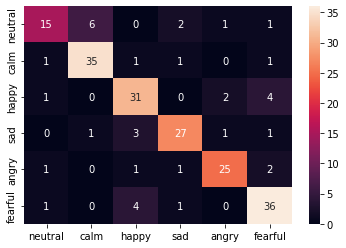

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(emo_test,abc))

acc = float(accuracy_score(emo_test,abc))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(emo_test,abc)
#df_cm = pd.DataFrame(cm)
class_names = ['neutral','calm', 'happy','sad','angry', 'fearful' ]
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names,)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()